In [1]:
import pickle
import CO2_Dataset_Preparation
import CO2_functions
import CO2_Processing
from CO2_Dataset_Preparation import *
from CO2_functions import * 
from CO2_Processing import *

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import importlib
importlib.reload(CO2_functions)
importlib.reload(CO2_Processing)
importlib.reload(CO2_Dataset_Preparation)

from CO2_Dataset_Preparation import *
from CO2_functions import *
from CO2_Processing import *

%load_ext rpy2.ipython

In [4]:
path = 'Processed_Test'
tower = 'Picarro'
position_number = 1
excess_rolls_sec = [600] #these specify the rolling window on which a minimum is applied for excess 
vent_bool = True
wbb_bool = True
downsample_sec = 1

data = Processed_Set(tower,position_number,excess_rolls_sec,vent_bool=vent_bool,wbb_bool=wbb_bool)
data._retrieve_data(path)
data._apply_excess(delete_min_cols = False)
data._combine_vent_tower(downsample_sec)

Applying excess using minimum on windows: [600] seconds
combining vent and tower data into a dataframe
Downsampling by mean at 1 seconds
Downsampling by mean at 1 seconds


In [2]:
excess_rolls_sec = [1,10,60,600,3600]#,6000,36000] #these specify the rolling window on which a minimum is applied for excess 
tower = 'Multi'

for i in range(1,4):
    position_number = i
    downsample_sec = 1

    data = Processed_Set(tower,position_number,excess_rolls_sec,vent_bool = True,wbb_bool=True)
    data._retrieve_data('../CO2_Data_Processed/')
    data._apply_excess(delete_min_cols=True)
    data._combine_vent_tower(downsample_sec)

    # if tower == 'Picarro':
    #     data._add_rolling_wind(wind_rolls,False)
    # data._column_shifter(lag_shifts,delete=False)
    # data._vent_on_only()

    data.df.to_csv(f'../CO2_Data_Processed/R_Dataframes/{tower}_{position_number}_excess.csv')


Applying excess using minimum on windows: [1, 10, 60, 600, 3600] seconds
combining vent and tower data into a dataframe
Downsampling by mean at 1 seconds
Downsampling by mean at 1 seconds
Applying excess using minimum on windows: [1, 10, 60, 600, 3600] seconds
combining vent and tower data into a dataframe
Downsampling by mean at 1 seconds
Downsampling by mean at 1 seconds
Applying excess using minimum on windows: [1, 10, 60, 600, 3600] seconds
combining vent and tower data into a dataframe
Downsampling by mean at 1 seconds
Downsampling by mean at 1 seconds


In [23]:
data.data['Multi']['CO2_1'] = data.data['Multi']['CO2_1']+6

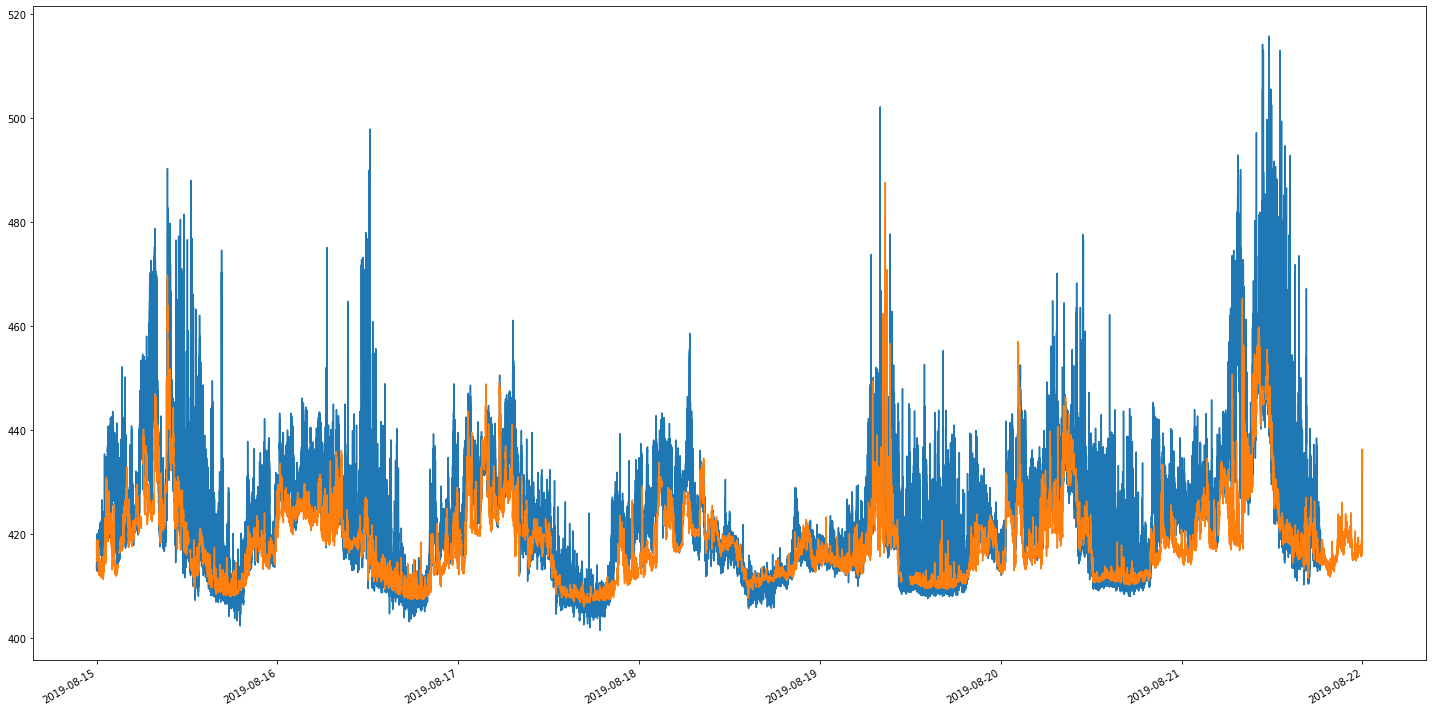

Is this an acceptable range? y


[                   Corrected_DT     Pic_CO2   Pic_CH4  Pic_Loc    ANEM_Y  \
 0       2019-08-15 00:00:00.000  414.091875  1.721805        1  0.043404   
 1       2019-08-15 00:00:00.100  413.699437  1.722210        1  0.020638   
 2       2019-08-15 00:00:00.200  413.654037  1.723372        1 -0.031284   
 3       2019-08-15 00:00:00.300  413.948799  1.726272        1 -0.092128   
 4       2019-08-15 00:00:00.400  414.061768  1.725397        1 -0.103394   
 ...                         ...         ...       ...      ...       ...   
 5852268 2019-08-21 18:33:46.800         NaN       NaN        1 -1.750213   
 5852269 2019-08-21 18:33:46.900         NaN       NaN        1 -1.687706   
 5852270 2019-08-21 18:33:47.000         NaN       NaN        1 -1.595319   
 5852271 2019-08-21 18:33:47.100         NaN       NaN        1 -1.612385   
 5852272 2019-08-21 18:33:47.200         NaN       NaN        1 -1.615745   
 
            ANEM_X    ANEM_Z  
 0       -0.293404  0.066596  
 1       -0.

In [42]:
graph = [\
         [data.data['Picarro'],'Corrected_DT','Pic_CO2'],\
         [data.data['Vent_Mass'],'Corrected_DT','WBB_CO2'],\
         #[wbb,'Corrected_DT','ws']
        ]

plot_refinement_all(graph,'stack')

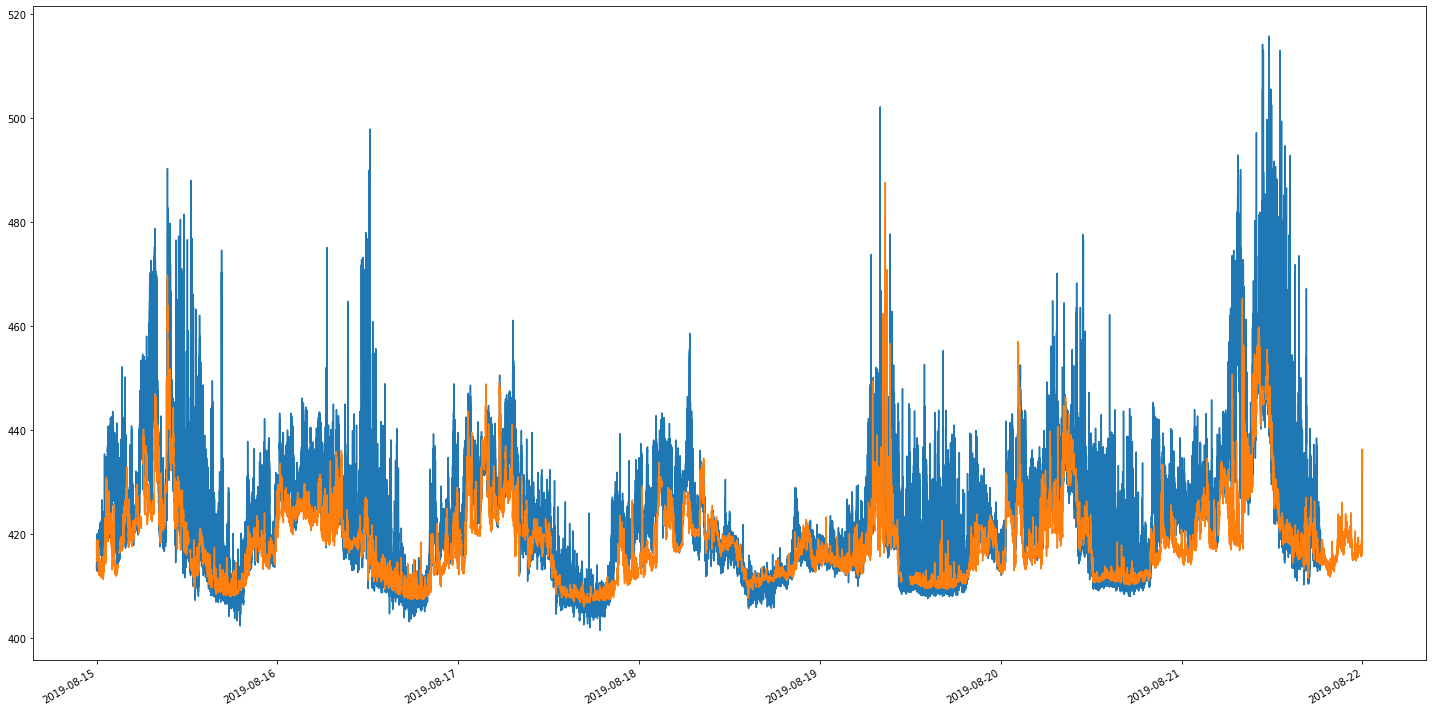

Is this an acceptable range? y


[                   Corrected_DT     Pic_CO2   Pic_CH4  Pic_Loc    ANEM_Y  \
 0       2019-08-15 00:00:00.000  414.091875  1.721805        1  0.043404   
 1       2019-08-15 00:00:00.100  413.699437  1.722210        1  0.020638   
 2       2019-08-15 00:00:00.200  413.654037  1.723372        1 -0.031284   
 3       2019-08-15 00:00:00.300  413.948799  1.726272        1 -0.092128   
 4       2019-08-15 00:00:00.400  414.061768  1.725397        1 -0.103394   
 ...                         ...         ...       ...      ...       ...   
 5852268 2019-08-21 18:33:46.800         NaN       NaN        1 -1.750213   
 5852269 2019-08-21 18:33:46.900         NaN       NaN        1 -1.687706   
 5852270 2019-08-21 18:33:47.000         NaN       NaN        1 -1.595319   
 5852271 2019-08-21 18:33:47.100         NaN       NaN        1 -1.612385   
 5852272 2019-08-21 18:33:47.200         NaN       NaN        1 -1.615745   
 
            ANEM_X    ANEM_Z  
 0       -0.293404  0.066596  
 1       -0.

In [12]:
graph = [\
         [data.data['Picarro'],'Corrected_DT','Pic_CO2'],\
         [data.data['Vent_Mass'],'Corrected_DT','WBB_CO2'],\
         #[wbb,'Corrected_DT','ws']
        ]

plot_refinement_all(graph,'stack')

# --------------------
# Wind Roll/Lag
# --------------------

In [90]:
tower = 'Picarro'
position_number = 1
downsample_sec = 1
wind_rolls = [1,5,10,30,60,600]
lag_shifts = [5,10,20,30,45,60,90,120]

data = Processed_Set(tower,position_number,excess_rolls_sec,vent_bool = True,wbb_bool=False)
data._retrieve_data('../CO2_Data_Processed/')
data._apply_excess(delete_min_cols = True)
data._combine_vent_tower(downsample_sec)
data._add_rolling_wind(wind_rolls,delete_anem_bool = False)

Applying excess using minimum on windows: [10, 60, 3600] seconds
combining vent and tower data into a dataframe
Downsampling by mean at 1 seconds
Downsampling by mean at 1 seconds


In [92]:
data.df

,Pic_CO2,Pic_CH4,Pic_Loc,ANEM_X,ANEM_Y,ANEM_Z,excess_r10_Pic_CO2,excess_r10_Pic_CH4,excess_r60_Pic_CO2,excess_r60_Pic_CH4,...,roll_5_ws,roll_5_wd,roll_10_ws,roll_10_wd,roll_30_ws,roll_30_wd,roll_60_ws,roll_60_wd,roll_600_ws,roll_600_wd
Corrected_DT,,,,,,,,,,,,,,,,,,,,,
2019-08-15 00:00:00,401.177619,1.722919,1.0,-0.315575,-0.046262,0.038520,0.585682,0.003730,0.626578,0.007201,...,0.486627,80.394186,0.537514,74.934988,0.489392,75.202595,0.501535,77.935803,0.549624,62.733595
2019-08-15 00:00:01,401.100238,1.723759,1.0,-0.344498,-0.066340,-0.039098,0.514668,0.004655,0.549196,0.008055,...,0.519378,77.009069,0.554165,73.025443,0.485415,75.070266,0.504217,77.731741,0.549570,62.696037
2019-08-15 00:00:02,401.053224,1.724143,1.0,-0.372218,-0.062104,-0.074662,0.472304,0.005101,0.502182,0.008452,...,0.537514,74.934988,0.557752,71.888587,0.484524,74.790565,0.507185,77.197218,0.549378,62.663688
2019-08-15 00:00:03,401.236924,1.723348,1.0,-0.436733,-0.164199,-0.151772,0.659549,0.004353,0.685882,0.007669,...,0.575739,71.745341,0.553296,70.830225,0.484509,74.550973,0.501336,76.048996,0.549435,62.659047
2019-08-15 00:00:04,401.319854,1.725913,1.0,-0.431376,-0.172617,-0.141552,0.745271,0.006954,0.768812,0.010245,...,0.594156,69.381677,0.550307,70.923946,0.487147,74.394908,0.492818,75.056571,0.549772,62.701284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-21 23:59:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-21 23:59:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-21 23:59:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


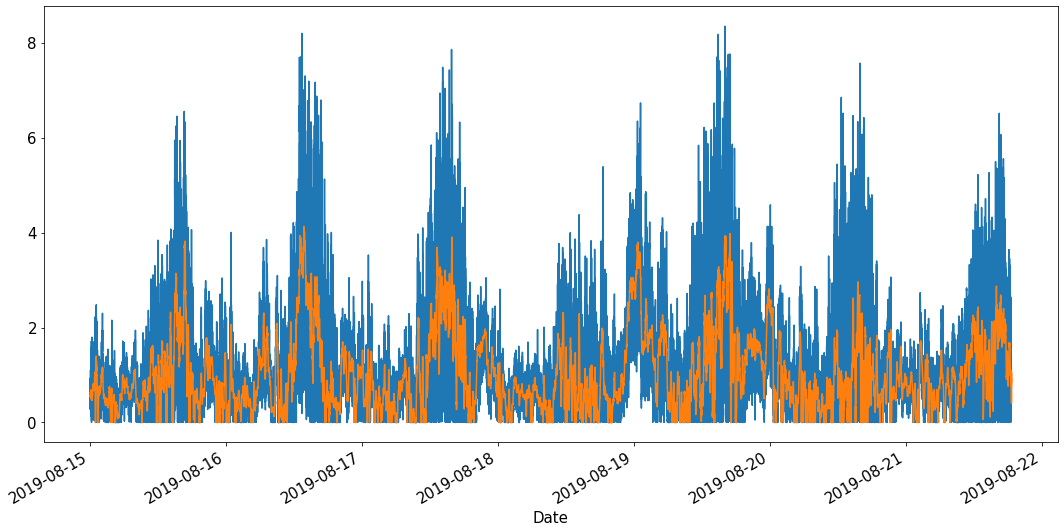

In [94]:
labsize = 15

subset_dates = ['2019-08-15','2019-08-21']
df = data.df

fig,ax=plt.subplots(figsize=[15,7.5])

ax.plot(df.index,df['roll_10_ws'])
ax.plot(df.index,df['roll_600_ws'])

#ax.plot(df.index,df['min_r3600_Pic_CO2'],linewidth=4,color='black')

ax.set_xlabel('Date',size=labsize)
ax.tick_params(axis='both', which='major', labelsize=labsize)

plt.gcf().autofmt_xdate()
fig.tight_layout()
plt.show()

# --------------------
# Baseline Plotting
# --------------------

In [4]:
excess_rolls_sec = [10,60,600,3600]#,6000,36000] #these specify the rolling window on which a minimum is applied for excess 
tower = 'Picarro'

position_number = 1
downsample_sec = 100
wind_rolls = [5,10,30,60,600]
lag_shifts = [5,10,20,30,45,60,90,120]

data = Processed_Set(tower,position_number,excess_rolls_sec,vent_bool = True,wbb_bool=False)
data._retrieve_data('../CO2_Data_Processed/')

In [5]:
data._apply_excess(delete_min_cols = False)

Applying excess using minimum on windows: [10, 60, 600, 3600] seconds


/uufs/chpc.utah.edu/common/home/u0890904/software/pkg/miniconda3/envs/CO2_Eddy/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/uufs/chpc.utah.edu/common/home/u0890904/software/pkg/miniconda3/envs/CO2_Eddy/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  wa

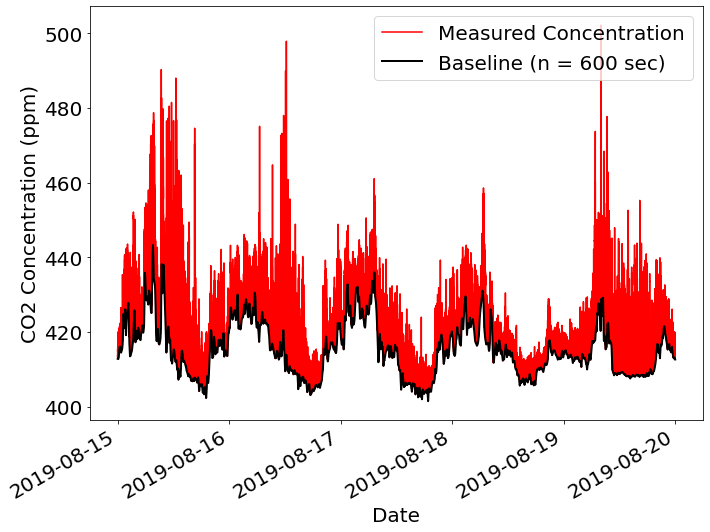

In [6]:
labsize = 20

ghg = 'Pic_CO2'

subset_dates = ['2019-08-15','2019-08-20']
df = data.data[tower].loc[(data.data[tower].index>f'{subset_dates[0]} 00:00:00')&\
                          (data.data[tower].index<f'{subset_dates[1]} 00:00:00')]

#add means
df[f'mean_r3600_{ghg}']  = df[f'{ghg}'].rolling(10000,center=True).mean()





fig,ax=plt.subplots(figsize=[10,7.5])

thresh = 440
minidf = df.loc[df[f'{ghg}']<thresh]

#EXCESS OVER ZERO LINE
# ax.plot(df.index,df[f'excess_r3600_{ghg}'],color='red',alpha=1)
# ax.hlines(0,df.index[0],df.index[-1],color='black',linewidth=2)

ax.plot(df.index,df[f'{ghg}'],color='red',alpha=1,label = 'Measured Concentration')
ax.plot(df.index,df[f'min_r600_{ghg}'].rolling(600).mean(),linewidth=2,color='black',label = 'Baseline (n = 600 sec)')



if ghg == 'Pic_CH4':
    ylab = 'CH4 Concentration (ppm)'
elif ghg == 'Pic_CO2':
    ylab = 'CO2 Concentration (ppm)'

    
ylab = 'CO2 Concentration (ppm)'

ax.set_xlabel('Date',size=labsize)
ax.set_ylabel(ylab,size=labsize)

ax.tick_params(axis='both', which='major', labelsize=labsize)

ax.legend(fontsize = labsize,loc = 1)

plt.gcf().autofmt_xdate()
fig.tight_layout()
plt.show()

fig.savefig('../CO2_Data_Processed/Plots_Figs/CO2_excess.png')

In [ ]:
#new = wind_add(new,'ANEM_X','ANEM_Y')
graph = [\
         [new,'Corrected_DT','Pic_CO2'],\
         #[new,'Corrected_DT','excess_Pic_CH4'],\
         [new,'Corrected_DT','wd'],\
         [new,'Corrected_DT','m_dot']\
        ]

test_df = plot_refinement_all(graph,'separate')

# -----------------------------
# R
# -----------------------------
Testing of using R in Python. Trouble getting rpy2 to work with openair. This section simply converts to dataframe to R dataframe for use in openair. Shown image is a generated JPG from running R scripts. 

In [23]:
# df = dataframe.copy()
# pic = df.resample("10S").mean()#.agg(dict(Pic_CO2='max',Pic_CH4='max',ANEM_Y='mean',ANEM_X='mean',ANEM_Z='mean',Pic_Loc = 'last'))
# pic = wind_add(pic,'ANEM_X','ANEM_Y')

import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

print('here')
with localconverter(ro.default_converter + pandas2ri.converter):
    r_df = ro.conversion.py2rpy(df)

here


In [24]:
%%R -i r_df
.libPaths()
write.csv(r_df,file='../CO2_Data_Processed/R_Dataframes/pic_6.Rdat')

<img src="Openair/data.jpg">

# ---------------------------------
# DASH/PLOTLY
# ---------------------------------

Didn't get very far with this, more work to be done. 

In [ ]:
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
import numpy as np
from scipy import special

py.offline.init_notebook_mode(connected=True)

In [ ]:
d = vent_data_all
x = d.index

layout = go.Layout(
    title = 'Vent_Data',
    yaxis = dict(
        title = 'Mass Flow (g/s)'
    ),
    xaxis = dict(
        title = 'Date Time'
    )
)

trace1 = go.Scattergl(
    x = x,
    y = d['m_dot'],
    mode = 'lines',
    name = 'm_dot',
)

fig = go.Figure(data=trace1,layout=layout)
py.offline.iplot(fig)
    


In [ ]:
x = d.index

layout = go.Layout(
    title = 'SIM',
    yaxis = dict(
        title = 'volts'
    ),
    xaxis = dict(
        title = 'ns'
    )
)


def update_plot(CO2_x, roll):
    data = []
    print(roll)
    for c in CO2_x:
        trace1 = go.Scattergl(
            x = x,
            y = d.rolling(roll,center=True,min_periods=1).mean()[f'CO2_{c}'],
            mode = 'lines',
            name = 'CO2_{}'.format(c),
#             line=dict(
#                 shape='spline'
#             )
        )
        data.append(trace1)
    fig = go.Figure(data=data,layout=layout)
    py.offline.iplot(fig)
    
    

CO2_x = widgets.SelectMultiple(options=list(range(1,4)),value=(1,),description='CO2')
roll = widgets.Select(
    options = [1,10,100,1000],
    value = 1,
    description='roll'    
)

widgets.interactive(update_plot,CO2_x=CO2_x,roll=roll)